In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import random
from tqdm import trange

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

In [15]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW_NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW_NB15/test.csv')
print(test_raw.shape)

(82332, 45)
(175341, 45)


In [7]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [8]:
# Seperate label and drop unnecessary features
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']

In [9]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

test_X1.isna().sum().sum()

0

In [16]:
# estimite time consumption of model trainin/testing with different number of features
train_time_all = []
test_time_all = []
f1_all = []

mean_all = []

for model in [RidgeClassifier(random_state=0), GradientBoostingClassifier(random_state=0)]:
    for i in range(10):
        cols = []
        candidates = train_X1.columns.to_list()
        train_time = []
        test_time = []
        f1 = []
        train_X2 = pd.DataFrame()
        test_X2 = pd.DataFrame()

        for k in trange(train_X1.shape[1]):
            # randomly choose a feature and add to the subset
            f = random.choice(candidates)
            candidates.remove(f)
            train_X2[f] = train_X1[f].copy()
            test_X2[f] = test_X1[f].copy()
            # measure time of model training
            second = time.time()
            model.fit(train_X2, train_Y)
            second2 = time.time()
            train_time.append(second2 - second)
            # measure time of model testing
            second = time.time()
            predict = model.predict(test_X2)
            second2 = time.time()
            f1.append(f1_score(test_Y, predict))
            test_time.append(second2 - second)
        train_time_all.append(train_time)
        test_time_all.append(test_time)
        f1_all.append(f1)
    # mean over 10 iterations
    mean_all.append((np.mean(train_time_all, axis=0), np.mean(test_time_all, axis=0), np.mean(f1_all, axis=0)))

100%|██████████| 39/39 [07:32<00:00, 11.61s/it]


In [19]:
mean_all[0][0]

array([0.00947938, 0.01281981, 0.01357503, 0.01536186, 0.01619935,
       0.01770864, 0.02004969, 0.01917162, 0.02155268, 0.02234783,
       0.02453771, 0.02537937, 0.02708123, 0.02797949, 0.02962704,
       0.02982218, 0.03232484, 0.03303132, 0.03491595, 0.03544934,
       0.03824685, 0.03963809, 0.04025936, 0.0408555 , 0.04409206,
       0.04339671, 0.04649584, 0.04624219, 0.04799619, 0.04967372,
       0.05233328, 0.05205605, 0.05389836, 0.05553741, 0.05625663,
       0.05908191, 0.06289153, 0.06192355, 0.0631712 ])

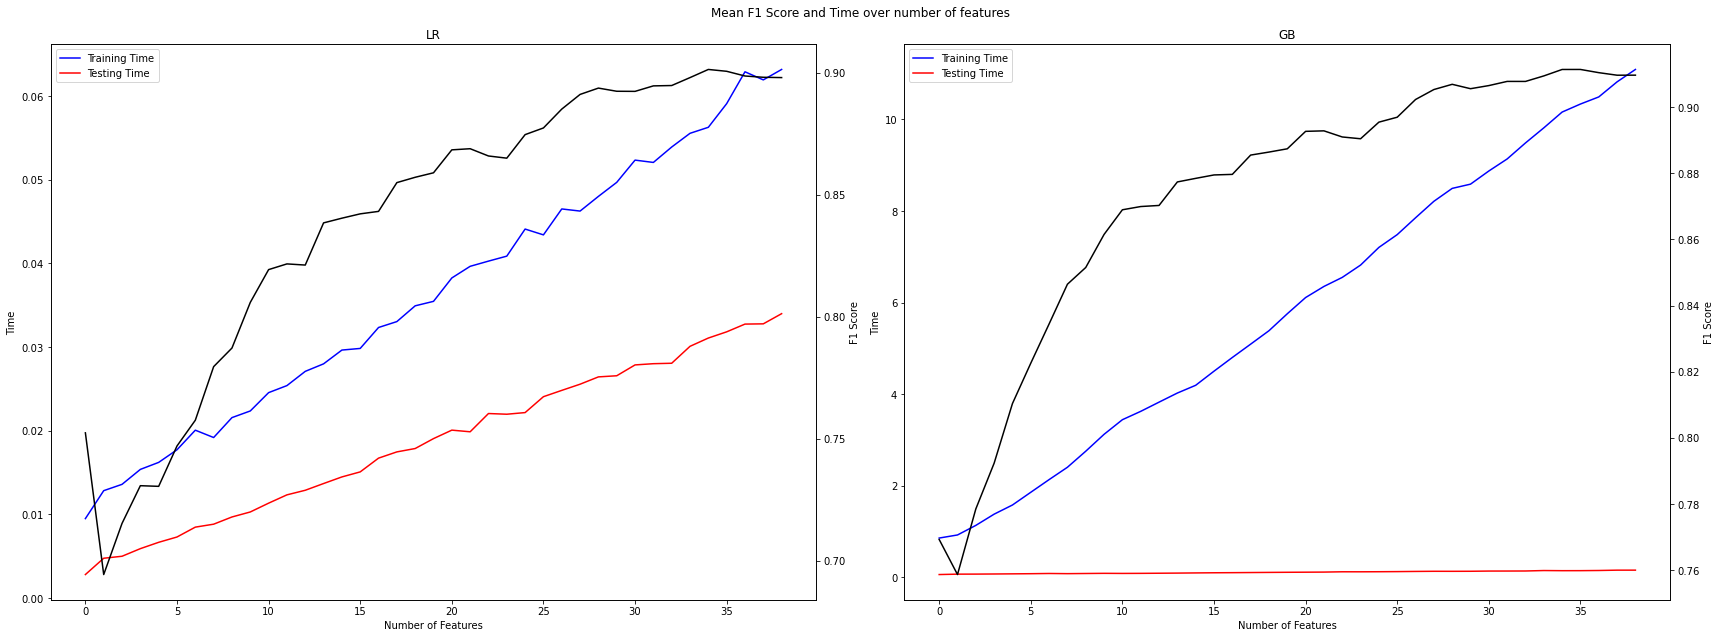

In [25]:
plt.subplots(1, 2, figsize=(24, 9))

model_name = ['LR', 'GB']
plt.suptitle(f'Mean F1 Score and Time over number of features')
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax2 = ax.twinx()
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Time')
    ax2.set_ylabel('F1 Score')

    ax.plot(range(train_X1.shape[1]), mean_all[i][0], color='blue', linestyle='-', label='Training Time')
    ax.plot(range(train_X1.shape[1]), mean_all[i][1], color='red', linestyle='-', label='Testing Time')
    ax2.plot(range(train_X1.shape[1]), mean_all[i][2], color='black', linestyle='-', label='F1 Score')
    ax.set_title(model_name[i])
    ax.legend()

plt.tight_layout()
plt.show()